In [1]:
import torch
import torch.nn as nn

In [2]:
class Block1(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.conv1 = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
    self.instnorm = nn.InstanceNorm3d(output_channels)
    self.lrelu = nn.LeakyReLU()
    self.conv2 = nn.Conv3d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
  def forward(self, x):
    x = self.conv1(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    x = self.conv2(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    return x

class ConvBlockEncoder(nn.Module): # need to add nn.Module here
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.conv1 = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=2, padding=1) # before padding it was 64 x 63 x 63 x 63. by adding 1, you add one to each dimension needed
    self.instnorm = nn.InstanceNorm3d(output_channels)
    self.lrelu = nn.LeakyReLU()
    self.conv2 = nn.Conv3d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
  def forward(self, x):
    x = self.conv1(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    x = self.conv2(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    return x

class ConvBlockDecoder(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.transconv = nn.ConvTranspose3d(in_channels=input_channels, out_channels=input_channels, kernel_size=2, stride=2)
    self.conv1 = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
    self.instnorm = nn.InstanceNorm3d(output_channels)
    self.lrelu = nn.LeakyReLU()
    self.conv2 = nn.Conv3d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
  def forward(self, x, concat_tensor):
    x = self.transconv(x)
    # print("after transpose: " + str(x.shape))
    x = torch.add(x, concat_tensor)
    # print("after concat: " + str(x.shape))
    x = self.conv1(x)
    # print("after conv1: " + str(x.shape))
    x = self.instnorm(x)
    x = self.lrelu(x)
    x = self.conv2(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    return x

class nnUNet(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.convblock1 = Block1(4, 32)
    self.convblock2 = ConvBlockEncoder(32, 64)
    self.convblock3 = ConvBlockEncoder(64, 128)
    self.convblock4 = ConvBlockEncoder(128, 256)
    self.convblock5 = ConvBlockEncoder(256, 320)
    self.convblock6 = ConvBlockEncoder(320, 320)

    self.convblock7 = ConvBlockDecoder(320, 256)
    self.convblock8 = ConvBlockDecoder(256, 128)
    self.convblock9 = ConvBlockDecoder(128, 64)
    self.convblock9b = nn.Conv3d(in_channels=64, out_channels=3, kernel_size=1, stride=1) # output is 3 channels for WT, ET, TC
    self.convblock10 = ConvBlockDecoder(64, 32)
    self.convblock10b = nn.Conv3d(in_channels=32, out_channels=3, kernel_size=1, stride=1) # output is 3 channels for WT, ET, TC
    self.convblock11 = ConvBlockDecoder(32, 32)
    self.convblock11b = nn.Conv3d(in_channels=32, out_channels=3, kernel_size=1, stride=1) # output is 3 channels for WT, ET, TC

    self.softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, ):
    print(x.shape) # [4, 128, 128, 128]

    # ENCODER
    x1 = self.convblock1(x)
    print(x1.shape) # [32, 128, 128, 128]

    x2 = self.convblock2(x1)
    print(x2.shape) # [64, 64, 64, 64]

    x3 = self.convblock3(x2)
    print(x3.shape) # [128, 32, 32, 32]

    x4 = self.convblock4(x3)
    print(x4.shape) # [256, 16, 16, 16]

    x5 = self.convblock5(x4)
    print(x5.shape) # [320, 8, 8, 8]

    x6 = self.convblock6(x5)
    print(x6.shape) # [320, 4, 4, 4]

    x7 = self.convblock7(x6, x5)
    print(x7.shape) # [256, 8, 8, 8]

    x8 = self.convblock8(x7, x4)
    print(x8.shape) # [128, 16, 16, 16]

    x9 = self.convblock9(x8, x3)
    print(x9.shape) # [64, 32, 32, 32] - add one softmax here

    x9b = self.convblock9b(x9) 
    print(x9b.shape) # [3, 32, 32, 32]

    # classes list for all levels of deep supervision in model
    class1_probabilities = []
    class2_probabilities = []
    class3_probabilities = []

    # dissect it from here into different classes
    class1prob1 = x9b[:, 0, :, :, :]
    class2prob1 = x9b[:, 1, :, :, :]
    class3prob1 = x9b[:, 2, :, :, :]

    # take each class and apply sigmoid
    print("sigmoid")
    sig_class1prob1 = self.sigmoid(class1prob1)
    print(sig_class1prob1.shape)
    sig_class2prob1 = self.sigmoid(class2prob1)
    print(sig_class2prob1.shape)
    sig_class3prob1 = self.sigmoid(class3prob1)
    print(sig_class3prob1.shape)

    # put the class into the list for its class
    class1_probabilities.append(sig_class1prob1)
    class2_probabilities.append(sig_class2prob1)
    class3_probabilities.append(sig_class3prob1)

    # prob3 = self.softmax(x9b)
    # print(prob3.shape) # [4, 32, 32, 32]

    x10 = self.convblock10(x9, x2)
    print(x10.shape) # [32, 64, 64, 64] - add one softmax here

    x10b = self.convblock10b(x10)
    print(x10b.shape) # [4, 64, 64, 64]

    # dissect it from here into different classes
    class1prob1 = x10b[:, 0, :, :, :]
    class2prob1 = x10b[:, 1, :, :, :]
    class3prob1 = x10b[:, 2, :, :, :]

    # take each class and apply sigmoid
    print("sigmoid")
    sig_class1prob2 = self.sigmoid(class1prob1)
    print(sig_class1prob2.shape)
    sig_class2prob2 = self.sigmoid(class2prob1)
    print(sig_class2prob2.shape)
    sig_class3prob2 = self.sigmoid(class3prob1)
    print(sig_class3prob2.shape)

    # put the class into the list for its class
    class1_probabilities.append(sig_class1prob2)
    class2_probabilities.append(sig_class2prob2)
    class3_probabilities.append(sig_class3prob2)

    # prob2 = self.softmax(x10b)
    # print(prob2.shape) # [4, 64, 64, 64]

    x11 = self.convblock11(x10, x1)
    print(x11.shape) # [32, 128, 128, 128]

    x11b = self.convblock11b(x11)
    print(x11b.shape) # [4, 128, 128, 128]

    # dissect it from here into different classes
    class1prob1 = x11b[:, 0, :, :, :]
    class2prob1 = x11b[:, 1, :, :, :]
    class3prob1 = x11b[:, 2, :, :, :]

    # take each class and apply sigmoid
    print("sigmoid")
    sig_class1prob3 = self.sigmoid(class1prob1)
    print(sig_class1prob3.shape)
    sig_class2prob3 = self.sigmoid(class2prob1)
    print(sig_class2prob3.shape)
    sig_class3prob3 = self.sigmoid(class3prob1)
    print(sig_class3prob3.shape)

    # put the class into the list for its class
    class1_probabilities.append(sig_class1prob3)
    class2_probabilities.append(sig_class2prob3)
    class3_probabilities.append(sig_class3prob3)
    
    # prob1 = self.softmax(x11b)
    # print(prob1.shape) # [3, 128, 128, 128] - i thought that the shape would change when using softmax, but only the values change to add up to 1

    print(len(class1_probabilities), len(class2_probabilities), len(class3_probabilities))
    print(len(class1_probabilities[0]), len(class2_probabilities[0]), len(class3_probabilities[0]))

    return class1_probabilities, class2_probabilities, class3_probabilities

In [3]:
# class1_outputs = [class1_from_prediction1, class1_from_prediction2, class1_from_prediction3]
# class2_outputs = [class2_from_prediction1, class2_from_prediction2, class2_from_prediction3]
# class3_outputs = [class3_from_prediction1, class3_from_prediction2, class3_from_prediction3]

In [4]:
"""
when dim = 1
>>> torch.cat((x, x, x), 1)
tensor([[ 0.6580, -1.0969, -0.4614,  0.6580, -1.0969, -0.4614,  0.6580,
         -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497, -0.1034, -0.5790,  0.1497, -0.1034,
         -0.5790,  0.1497]])

softmax confusion:
- https://stackoverflow.com/questions/49036993/pytorch-softmax-what-dimension-to-use
- https://discuss.pytorch.org/t/softmax-across-3d-tensor/83754
"""

'\nwhen dim = 1\n>>> torch.cat((x, x, x), 1)\ntensor([[ 0.6580, -1.0969, -0.4614,  0.6580, -1.0969, -0.4614,  0.6580,\n         -1.0969, -0.4614],\n        [-0.1034, -0.5790,  0.1497, -0.1034, -0.5790,  0.1497, -0.1034,\n         -0.5790,  0.1497]])\n\nsoftmax confusion:\n- https://stackoverflow.com/questions/49036993/pytorch-softmax-what-dimension-to-use\n- https://discuss.pytorch.org/t/softmax-across-3d-tensor/83754\n'

In [5]:
x = torch.rand(size=(2, 4, 128, 128, 128), dtype=torch.float32)
# print(x.shape)

model = nnUNet(x.shape)
# print(model)
print()

probability1, probability2, probability3 = model(x)
# print(out.shape)


torch.Size([2, 4, 128, 128, 128])
torch.Size([2, 32, 128, 128, 128])
torch.Size([2, 64, 64, 64, 64])
torch.Size([2, 128, 32, 32, 32])
torch.Size([2, 256, 16, 16, 16])
torch.Size([2, 320, 8, 8, 8])
torch.Size([2, 320, 4, 4, 4])
torch.Size([2, 256, 8, 8, 8])
torch.Size([2, 128, 16, 16, 16])
torch.Size([2, 64, 32, 32, 32])
torch.Size([2, 3, 32, 32, 32])
sigmoid
torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 64, 64, 64])
torch.Size([2, 3, 64, 64, 64])
sigmoid
torch.Size([2, 64, 64, 64])
torch.Size([2, 64, 64, 64])
torch.Size([2, 64, 64, 64])
torch.Size([2, 32, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
sigmoid
torch.Size([2, 128, 128, 128])
torch.Size([2, 128, 128, 128])
torch.Size([2, 128, 128, 128])
3 3 3
2 2 2


In [6]:
# probability1, probability2, probability3 = out

In [7]:
print(probability1[0].shape)
print(probability2[0].shape)
print(probability3[0].shape)
print(probability1[1].shape)
print(probability2[1].shape)
print(probability3[1].shape)
print(probability1[2].shape)
print(probability2[2].shape)
print(probability3[2].shape)

torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 32, 32])
torch.Size([2, 64, 64, 64])
torch.Size([2, 64, 64, 64])
torch.Size([2, 64, 64, 64])
torch.Size([2, 128, 128, 128])
torch.Size([2, 128, 128, 128])
torch.Size([2, 128, 128, 128])


In [ ]:
probability1

In [ ]:
probability2

In [ ]:
probability3

In [11]:
import numpy as np

In [12]:
randomized_training_images = []
for i in range(2):
  newx = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_training_images.append(newx)

In [13]:
print(len(randomized_training_images))
print(randomized_training_images[0].shape)
# print(randomized_training_images[0])

2
torch.Size([1, 4, 128, 128, 128])


In [14]:
randomized_training_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_training_segmentations.append(newy)

In [15]:
print(len(randomized_training_segmentations))
print(randomized_training_segmentations[0].shape)
# print(randomized_training_segmentations[1])

2
torch.Size([1, 3, 128, 128, 128])


In [16]:
randomized_training_data = list(zip(randomized_training_images, randomized_training_segmentations))

In [17]:
trainloader = torch.utils.data.DataLoader(dataset=randomized_training_data, batch_size=2, shuffle=True) # batch size should be 5

In [18]:
len(trainloader)

1

In [19]:
randomized_validation_images = []
for i in range(2):
  newy = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_validation_images.append(newy)

In [20]:
print(len(randomized_validation_images))
print(randomized_validation_images[0].shape)

2
torch.Size([1, 4, 128, 128, 128])


In [21]:
randomized_validation_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_validation_segmentations.append(newy)

In [22]:
print(len(randomized_validation_segmentations))
print(randomized_validation_segmentations[0].shape)

2
torch.Size([1, 3, 128, 128, 128])


In [23]:
randomized_validation_data = list(zip(randomized_validation_images, randomized_validation_segmentations))

In [24]:
validationloader = torch.utils.data.DataLoader(dataset=randomized_validation_data, batch_size=2, shuffle=True) # batch size should be 5

In [25]:
len(validationloader)

1

In [26]:
randomized_testing_images = []
for i in range(2):
  newy = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_testing_images.append(newy)

In [27]:
print(len(randomized_testing_images))
print(randomized_testing_images[0].shape)

2
torch.Size([1, 4, 128, 128, 128])


In [28]:
randomized_testing_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_testing_segmentations.append(newy)

In [29]:
print(len(randomized_testing_segmentations))
print(randomized_testing_segmentations[0].shape)

2
torch.Size([1, 3, 128, 128, 128])


In [30]:
randomized_testing_data = list(zip(randomized_testing_images, randomized_testing_segmentations))
testingloader = torch.utils.data.DataLoader(dataset=randomized_testing_data, batch_size=2, shuffle=True) # batch size should be 5

In [31]:
"""
nnU-Net
- training objective is the sum of Dice [21,20] and cross-entropy loss
- the loss operates on the three class labels edema, necrosis and enhancing tumor
- whole tumor (consisting of all 3 classes), tumor core (non-enh. & necrosis + enh. tumor) and enhancing tumor
- to this end, we replace the softmax nonlinearity in our network architecture with a sigmoid + change the optimization target to the 3 tumor subregions
- also replace the crossentropy loss term with a binary cross-entropy that optimizes each of the regions independently
"""

'\nnnU-Net\n- training objective is the sum of Dice [21,20] and cross-entropy loss\n- the loss operates on the three class labels edema, necrosis and enhancing tumor\n- whole tumor (consisting of all 3 classes), tumor core (non-enh. & necrosis + enh. tumor) and enhancing tumor\n- to this end, we replace the softmax nonlinearity in our network architecture with a sigmoid + change the optimization target to the 3 tumor subregions\n- also replace the crossentropy loss term with a binary cross-entropy that optimizes each of the regions independently\n'

In [32]:
# chose to make this a class because when you call dice loss in criterion, you don't have anything to input, but when u run the prediction through inside the training, then you have params
# also because most sources I saw used a class
class DiceLoss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, true, pred):
    # flatten to easily do it pixel by pixel
    true = true.reshape(-1)
    pred = pred.reshape(-1)
    numerator = 2*(true*pred).sum()
    denominator = true.sum() + pred.sum()
    dice_loss = 1 - (numerator) / (denominator)
    return dice_loss

In [33]:
import torch.optim

# Loss Formula
As this paper (https://arxiv.org/pdf/2110.03352.pdf) mentions, deep supervision is used to compute the loss at different decoder levels

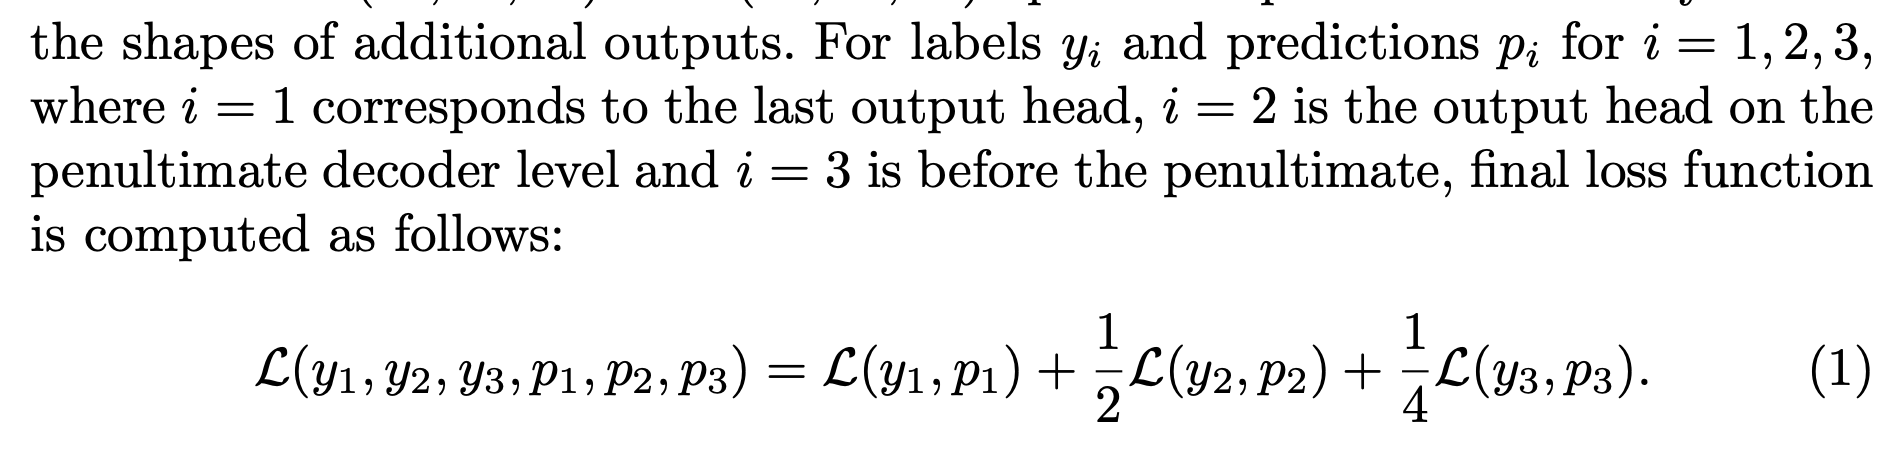

In [34]:
# epochs
epochs = 2 # should be 250
# loss
criterion1 = DiceLoss()
criterion2 = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum= 0.99)

In [35]:
# To compute the deep supervision loss, labels were first downsampled using nearest neighbor interpolation to the
# (64, 64, 64) and (32, 32, 32) spatial shapes such that they match the shapes of additional outputs
def makeDiffSizeCopies(class_seg):
  # should be [2, 128, 128, 128]
  # goes 32 channels -> 64 -> 128
  print(class_seg.shape)
  class_seg128 = class_seg
  class_seg64 = nn.Upsample(scale_factor=(0.5,0.5,0.5), mode='nearest')(class_seg128)
  print(class_seg64.shape)
  class_seg32 = nn.Upsample(scale_factor=(0.25,0.25,0.25), mode='nearest')(class_seg128)
  print(class_seg32.shape)
  class_segs = [class_seg32, class_seg64, class_seg128]
  return class_segs

In [36]:
new_seg = torch.rand(size=(2, 1, 128, 128, 128), dtype=torch.float32)
lst = makeDiffSizeCopies(new_seg)
print(len(lst))

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 64, 64, 64])
torch.Size([2, 1, 32, 32, 32])
3


In [37]:
def losses_perclass(class_probabilities, class_segmentations):
  # class1_probabilities, class2_probabilities, class3_probabilities = model(images)
  # basically each classx_probabilities has 3 items each with images in them
  print(len(class_probabilities))
  print(len(class_segmentations))

  tr_class_losses = []
  for i in range(len(class_probabilities)):
    print(class_probabilities[i].shape)
    # for each deep supervision level that has 2 images
    # have somethign like class1_probabilities, but replace each index with each of the items losses (so u have losses for each level)
    # and then use that list of losses to find that class loss
    dice_loss = criterion1(class_segmentations[i], class_probabilities[i])
    ce_loss = criterion1(class_segmentations[i], class_probabilities[i])
    # now add them to get the loss of this level for this class
    tr_class_losses.append(dice_loss+ce_loss)
  print(len(tr_class_losses))
  print(tr_class_losses)
  return tr_class_losses

In [38]:
import datetime

In [ ]:
training_losses = []
validation_losses = []

for i in range(epochs): # for every epoch
  start_epoch = datetime.datetime.now() # start the timer in datetime module
  training_loss = 0 # training loss for this epoch
  validation_loss = 0 # validation loss for this epoch
  print("training time")
  for images, segs in trainloader: # getting one batch from trainloader
    optimizer.zero_grad() # turn on gradients (used for forward and backprop)
    print(len(images), len(segs))
    print(images.shape)
    print(segs.shape)
    # need to squeeze the 1 in first dimension
    images = images.squeeze().clone().detach().requires_grad_(True)
    # segs = segs.long() - no
    segs = segs.squeeze().clone().detach().requires_grad_(True)
    print(images.shape)
    print(segs.shape)

    # for each class in the ground truth segmentation- take it apart, make different copies for different levels of deep supervision
    print()
    class1_segs = segs[:, 0, :, :, :]
    class1_segs = class1_segs.unsqueeze(dim=1)
    print(class1_segs.shape)
    class1_newsegs = makeDiffSizeCopies(class1_segs)
    print(len(class1_newsegs))
    print(class1_newsegs[0].shape)
    print(class1_newsegs[1].shape)
    print(class1_newsegs[2].shape)

    print()
    class2_segs = segs[:, 1, :, :, :]
    class2_segs = class2_segs.unsqueeze(dim=1)
    print(class2_segs.shape)
    class2_newsegs = makeDiffSizeCopies(class2_segs)
    print(len(class2_newsegs))
    print(class2_newsegs[0].shape)
    print(class2_newsegs[1].shape)
    print(class2_newsegs[2].shape)

    print()
    class3_segs = segs[:, 2, :, :, :]
    class3_segs = class3_segs.unsqueeze(dim=1)
    print(class3_segs.shape)
    class3_newsegs = makeDiffSizeCopies(class3_segs)
    print(len(class3_newsegs))
    print(class3_newsegs[0].shape)
    print(class3_newsegs[1].shape)
    print(class3_newsegs[2].shape)

    class1_probabilities, class2_probabilities, class3_probabilities = model(images)  # put images through model
    # basically each classx_probabilities has 3 items each with 2 images in them
    print(len(class1_probabilities))
    print(class1_probabilities[0].shape)
    print(class1_probabilities[1].shape)
    print(class1_probabilities[2].shape)

    # build function for getting class probabilities' loss
    tr_class1_losses = losses_perclass(class1_probabilities, class1_newsegs)
    tr_class2_losses = losses_perclass(class2_probabilities, class2_newsegs)
    tr_class3_losses = losses_perclass(class3_probabilities, class3_newsegs)
    
    print()
    # calculating final loss for every class - the first index is y3 loss (multiplied by 1/4), then y2 loss (multiplied by 1/2), then y1 loss
    class1_loss = 1/4*(tr_class1_losses[0]) + 1/2*(tr_class1_losses[1]) + tr_class1_losses[2]
    print(class1_loss)
    class2_loss = 1/4*(tr_class2_losses[0]) + 1/2*(tr_class2_losses[1]) + tr_class2_losses[2]
    print(class2_loss)
    class3_loss = 1/4*(tr_class3_losses[0]) + 1/2*(tr_class3_losses[1]) + tr_class3_losses[2]
    print(class3_loss)

    print()
    # build code for getting loss for epoch
    loss = (class1_loss + class2_loss + class3_loss)/3
    print(loss)
    loss.backward()
    training_loss += loss.item()
    print()

  print("validation time")
  for images, segs in validationloader: # getting one batch from validationloader
    optimizer.zero_grad() # keep gradients on (used for forward and backprop)
    print(len(images), len(segs))
    print(images.shape)
    print(segs.shape)
    # need to squeeze the 1 in first dimension
    images = images.squeeze().clone().detach().requires_grad_(True)
    # segs = segs.long() - no
    segs = segs.squeeze().clone().detach().requires_grad_(True)
    print(images.shape)
    print(segs.shape)

    # for each class in the ground truth segmentation- take it apart, make different copies for different levels of deep supervision
    print()
    class1_segs = segs[:, 0, :, :, :]
    class1_segs = class1_segs.unsqueeze(dim=1)
    print(class1_segs.shape)
    class1_newsegs = makeDiffSizeCopies(class1_segs)
    print(len(class1_newsegs))
    print(class1_newsegs[0].shape)
    print(class1_newsegs[1].shape)
    print(class1_newsegs[2].shape)

    print()
    class2_segs = segs[:, 1, :, :, :]
    class2_segs = class2_segs.unsqueeze(dim=1)
    print(class2_segs.shape)
    class2_newsegs = makeDiffSizeCopies(class2_segs)
    print(len(class2_newsegs))
    print(class2_newsegs[0].shape)
    print(class2_newsegs[1].shape)
    print(class2_newsegs[2].shape)

    print()
    class3_segs = segs[:, 2, :, :, :]
    class3_segs = class3_segs.unsqueeze(dim=1)
    print(class3_segs.shape)
    class3_newsegs = makeDiffSizeCopies(class3_segs)
    print(len(class3_newsegs))
    print(class3_newsegs[0].shape)
    print(class3_newsegs[1].shape)
    print(class3_newsegs[2].shape)

    class1_probabilities, class2_probabilities, class3_probabilities = model(images) # put images through model
    # basically each classx_probabilities has 3 items each with 2 images in them
    print(len(class1_probabilities))
    print(class1_probabilities[0].shape)
    print(class1_probabilities[1].shape)
    print(class1_probabilities[2].shape)

    # build function for getting class probabilities' loss
    tr_class1_losses = losses_perclass(class1_probabilities, class1_newsegs)
    tr_class2_losses = losses_perclass(class2_probabilities, class2_newsegs)
    tr_class3_losses = losses_perclass(class3_probabilities, class3_newsegs)
    
    print()
    # calculating final loss for every class - the first index is y3 loss (multiplied by 1/4), then y2 loss (multiplied by 1/2), then y1 loss
    class1_loss = 1/4*(tr_class1_losses[0]) + 1/2*(tr_class1_losses[1]) + tr_class1_losses[2]
    print(class1_loss)
    class2_loss = 1/4*(tr_class2_losses[0]) + 1/2*(tr_class2_losses[1]) + tr_class2_losses[2]
    print(class2_loss)
    class3_loss = 1/4*(tr_class3_losses[0]) + 1/2*(tr_class3_losses[1]) + tr_class3_losses[2]
    print(class3_loss)

    print()
    # build code for getting loss for epoch
    loss = (class1_loss + class2_loss + class3_loss)/3
    print(loss) # loss with random tensors will be really high because none of the tensors are related to each other
    loss.backward() # backpropagation
    validation_loss += loss.item() # add loss to validation loss

  # find avg losses for each image
  training_losses.append(training_loss/len(trainloader))
  validation_losses.append(validation_loss/len(validationloader))

  # print results about epoch
  print("Epoch: {}/{}... Training Loss: {}... Validation Loss: {}...".format(i+1,epochs, training_losses[-1], validation_losses[-1]))
  if validation_loss < min(validation_losses):
    print("Validation loss has decreased...saving model")
    torch.save(model.state_dict(), "fcn.pth")
  # end timer
  end_epoch = datetime.datetime.now()
  # calculate and print out time it takes for every epoch
  time_epoch = end_epoch-start_epoch
  print("Epoch time:", str(time_epoch), "\n")
  print()

In [40]:
print(training_losses)
print(validation_losses)

[1.7353047132492065, 1.7353047132492065]
[1.7356363534927368, 1.7356363534927368]


In [41]:
import matplotlib.pyplot as plt

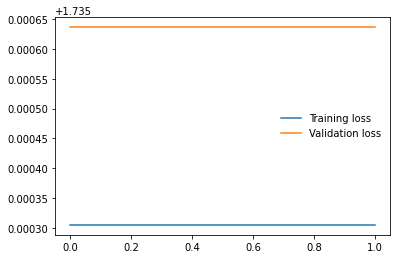

In [42]:
# visualize losses
plt.plot(training_losses, label="Training loss")
plt.plot(validation_losses, label="Validation loss")
plt.legend(frameon=False)

In [43]:
def dice_score(outputs, segmentations): # they find individual
  # outputs = torch.Size([2, 3, 128, 128, 128])
  # segmentations = torch.Size([2, 3, 128, 128, 128])
  # print(segmentations.shape)
  n_classes = segmentations.shape[1]
  region_scores = []
  for i in range(n_classes):
    outputs = outputs.view(-1)
    segmentations = segmentations.view(-1)
    numerator = 2*(outputs*segmentations).sum()
    denominator = outputs.sum() + segmentations.sum()
    dice = (numerator) / (denominator)
    region_scores.append(dice)
  return region_scores

In [44]:
from scipy.spatial.distance import directed_hausdorff

In [45]:
def hausdorff(outputs, segmentations): # for region for every image
  # print(outputs.shape)
  # print(segmentations.shape)

  # for each image in batch
  h_imgs = [0,0,0]
  len_imgs = len(outputs)

  for idx in range(len_imgs): # for each image
    out = outputs[idx]
    seg = segmentations[idx]
    n_classes = out.shape[0]
    # print(n_classes)

    region_hd_scores = []
    for i in range(n_classes): # for each class
      region_out = out[i]
      region_seg = seg[i]
      # print(region_out.shape)
      # print(region_seg.shape)

      total_hd_image = 0
      for j in range(region_out.shape[0]): # for each slice
        out_slice = region_out[j]
        seg_slice = region_seg[j]
        # print(out_slice.shape)
        # print(seg_slice.shape)
        a = directed_hausdorff(out_slice, seg_slice)[0]
        b = directed_hausdorff(seg_slice, out_slice)[0]
        hd_slice = max(a, b)
        total_hd_image += hd_slice
      avg_hd_image = total_hd_image/region_out.shape[0]
      # print(avg_hd_image)
      region_hd_scores.append(avg_hd_image)
    # print(region_hd95_scores)
    h_imgs[0] += region_hd_scores[0]
    h_imgs[1] += region_hd_scores[1]
    h_imgs[2] += region_hd_scores[2]
  
  for each in range(len(h_imgs)):
    h_imgs[each] = h_imgs[each]/len_imgs
  
  print(h_imgs)

  return h_imgs

In [46]:
"""
1 NECROTIC TUMOUR CORE (NCR — label 1) - index 0

2 GD-ENHANCING TUMOUR (ET — label 2) - index 1

3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3) - index 2
"""

'\n1 NECROTIC TUMOUR CORE (NCR — label 1) - index 0\n\n2 GD-ENHANCING TUMOUR (ET — label 2) - index 1\n\n3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3) - index 2\n'

In [47]:
for images, segs in testingloader:
    with torch.no_grad():
      print(len(images), len(segs))
      print(images.shape)
      print(segs.shape)
      # exclude first dimension of 1
      images = images.squeeze().clone().detach().requires_grad_(True)
      # segs = segs.long() - no
      segs = segs.squeeze().clone().detach().requires_grad_(True)
      print(images.shape)
      print(segs.shape)
      class1_probabilities, class2_probabilities, class3_probabilities = model(images) # put images through model
      # basically each classx_probabilities has 3 items each with 2 images in them
      print(len(class1_probabilities))
      print(class1_probabilities[2].shape)
      print(class2_probabilities[2].shape)
      print(class3_probabilities[2].shape)

      activated_outputs = torch.cat((class1_probabilities[2].unsqueeze(dim=1), class2_probabilities[2].unsqueeze(dim=1), class3_probabilities[2].unsqueeze(dim=1)),dim=1)
      print(activated_outputs.shape)
      
      region_scores = dice_score(activated_outputs, segs)

      print("\n", "......."*5, "\n")

      print(len(region_scores))
      print(region_scores)
      print()

      print("1 NECROTIC TUMOUR CORE (NCR — label 1)")
      print(region_scores[0].item())
      print()

      print("2 GD-ENHANCING TUMOUR (ET — label 2)")
      print(region_scores[1].item())
      print()

      print("3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3)")
      print(region_scores[2].item())

      print("\n", "......."*5, "\n")

      hd_scores = hausdorff(activated_outputs, segs)

      print()
      print(len(hd_scores))
      print(hd_scores)
      print()

      print("1 NECROTIC TUMOUR CORE (NCR — label 1)")
      print(hd_scores[0])
      print()

      print("2 GD-ENHANCING TUMOUR (ET — label 2)")
      print(hd_scores[1])
      print()

      print("3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3)")
      print(hd_scores[2])

2 2
torch.Size([2, 1, 4, 128, 128, 128])
torch.Size([2, 1, 3, 128, 128, 128])
torch.Size([2, 4, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
torch.Size([2, 4, 128, 128, 128])
torch.Size([2, 32, 128, 128, 128])
torch.Size([2, 64, 64, 64, 64])
torch.Size([2, 128, 32, 32, 32])
torch.Size([2, 256, 16, 16, 16])
torch.Size([2, 320, 8, 8, 8])
torch.Size([2, 320, 4, 4, 4])
torch.Size([2, 256, 8, 8, 8])
torch.Size([2, 128, 16, 16, 16])
torch.Size([2, 64, 32, 32, 32])
torch.Size([2, 3, 32, 32, 32])
sigmoid
torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 32, 32])
torch.Size([2, 32, 64, 64, 64])
torch.Size([2, 3, 64, 64, 64])
sigmoid
torch.Size([2, 64, 64, 64])
torch.Size([2, 64, 64, 64])
torch.Size([2, 64, 64, 64])
torch.Size([2, 32, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
sigmoid
torch.Size([2, 128, 128, 128])
torch.Size([2, 128, 128, 128])
torch.Size([2, 128, 128, 128])
3 3 3
2 2 2
3
torch.Size([2, 128, 128, 128])
torch.Size([2, 128, 128, 128])
torch.Si